# 🔎 Customer Churn Prediction – Modeling Task

### 📘 Problem Statement
The goal is to build a machine learning model that predicts **customer churn**.  
- Dataset is **imbalanced**: ~10% churners, ~90% non-churners.  
- Business importance: **Catching churners is critical** → retaining a customer is often much cheaper than acquiring a new one.  

### ⚠️ Challenge
- **Accuracy is misleading** in imbalanced data → a model could predict "non-churn" for everyone and still be ~90% accurate.  
- Metrics of focus should be:  
  - **Recall (Sensitivity)** → how many churners we catch.  
  - **Precision** → how many predicted churners are correct.  
  - **F1-score** → balance of precision & recall.  
  - **ROC-AUC & PR-AUC** → ability to rank churners vs non-churners.  

### 📑 Plan
We will evaluate 3 modeling approaches:  
1. **Random Forest (tuned)**  
2. **Random Forest + SMOTE**  
3. **XGBoost with recall focus + threshold tuning**  

At each step, we’ll check metrics, interpret results, and decide whether to move forward.  


# Feature Engineering and Modelling

---

1. Import packages
2. Load data
3. Modelling

---

## 1. Import packages

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_score, recall_score, roc_curve, auc
)

from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# Show plots inline in Jupyter
%matplotlib inline

# Set plot style
sns.set(color_codes=True)


---
## 2. Load data

In [3]:
df = pd.read_csv('data_for_predictions.csv')
df.drop(columns=["Unnamed: 0"], inplace=True)
df.head()

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,...,months_modif_prod,months_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
0,24011ae4ebbe3035111d65fa7c15bc57,0.000000,4.739944,0.000000,0.000000,0.0,0.444045,0.114481,0.098142,40.606701,...,2,6,0,0,1,0,0,0,0,1
1,d29c2c54acc38ff3c0614d0a653813dd,3.668479,0.000000,0.000000,2.280920,0.0,1.237292,0.145711,0.000000,44.311378,...,76,4,1,0,0,0,0,1,0,0
2,764c75f661154dac3a6c254cd082ea7d,2.736397,0.000000,0.000000,1.689841,0.0,1.599009,0.165794,0.087899,44.311378,...,68,8,0,0,1,0,0,1,0,0
3,bba03439a292a1e166f80264c16191cb,3.200029,0.000000,0.000000,2.382089,0.0,1.318689,0.146694,0.000000,44.311378,...,69,9,0,0,0,1,0,1,0,0
4,149d57cf92fc41cf94415803a877cb4b,3.646011,0.000000,2.721811,2.650065,0.0,2.122969,0.116900,0.100015,40.606701,...,71,9,1,0,0,0,0,1,0,0


---

## 3. Modelling

We now have a dataset containing features that we have engineered and we are ready to start training a predictive model. Remember, we only need to focus on training a `Random Forest` classifier.

### Data sampling

The first thing we want to do is split our dataset into training and test samples. The reason why we do this, is so that we can simulate a real life situation by generating predictions for our test sample, without showing the predictive model these data points. This gives us the ability to see how well our model is able to generalise to new data, which is critical.

A typical % to dedicate to testing is between 20-30, for this example we will use a 75-25% split between train and test respectively.

In [5]:
# Making a copy of our data
train_df = df.copy()

# Separatting target variable from independent variables
y = df['churn']
X = df.drop(columns=['id', 'churn'])
print(X.shape)
print(y.shape)

(14606, 61)
(14606,)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(10954, 61)
(10954,)
(3652, 61)
(3652,)


### Model training

Once again, we are using a `Random Forest` classifier in this example. A Random Forest sits within the category of `ensemble` algorithms because internally the `Forest` refers to a collection of `Decision Trees` which are tree-based learning algorithms. As the data scientist, you can control how large the forest is (that is, how many decision trees you want to include).

The reason why an `ensemble` algorithm is powerful is because of the laws of averaging, weak learners and the central limit theorem. If we take a single decision tree and give it a sample of data and some parameters, it will learn patterns from the data. It may be overfit or it may be underfit, but that is now our only hope, that single algorithm. 

With `ensemble` methods, instead of banking on 1 single trained model, we can train 1000's of decision trees, all using different splits of the data and learning different patterns. It would be like asking 1000 people to all learn how to code. You would end up with 1000 people with different answers, methods and styles! The weak learner notion applies here too, it has been found that if you train your learners not to overfit, but to learn weak patterns within the data and you have a lot of these weak learners, together they come together to form a highly predictive pool of knowledge! This is a real life application of many brains are better than 1.

Now instead of relying on 1 single decision tree for prediction, the random forest puts it to the overall views of the entire collection of decision trees. Some ensemble algorithms using a voting approach to decide which prediction is best, others using averaging. 

As we increase the number of learners, the idea is that the random forest's performance should converge to its best possible solution.

Some additional advantages of the random forest classifier include:

- The random forest uses a rule-based approach instead of a distance calculation and so features do not need to be scaled
- It is able to handle non-linear parameters better than linear based models

On the flip side, some disadvantages of the random forest classifier include:

- The computational power needed to train a random forest on a large dataset is high, since we need to build a whole ensemble of estimators.
- Training time can be longer due to the increased complexity and size of thee ensemble

In [11]:
# 1. Defining parameter grid
param_grid = {
    'n_estimators': [500,510,520,530,540,550,560],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'class_weight': [None, 'balanced']
}

# 2. Initializing model
rf = RandomForestClassifier(random_state=42)

# 3. Setting-up Randomized Search
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=20,             # number of combinations to try
    cv=3,                  # 3-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1              # use all CPU cores
)

# 4. Fitting the search
rf_random.fit(X_train, y_train)

# 5. Best parameters
print("Best Parameters:", rf_random.best_params_)

# 6. Predictions with best model
best_model = rf_random.best_estimator_
y_pred = best_model.predict(X_test)

# 7. Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC AUC Score:", roc_auc_score(y_test, best_model.predict_proba(X_test)[:,1]))


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'n_estimators': 540, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None, 'class_weight': 'balanced'}
Confusion Matrix:
 [[3278    8]
 [ 340   26]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95      3286
           1       0.76      0.07      0.13       366

    accuracy                           0.90      3652
   macro avg       0.84      0.53      0.54      3652
weighted avg       0.89      0.90      0.87      3652


ROC AUC Score: 0.6590311937712235


# 📘 Attempt 1: Random Forest + Hyperparameter Tuning

### 🔹 Approach
- Used **RandomForestClassifier** with **RandomizedSearchCV** for hyperparameter tuning.   
### 🔹 Best Parameters
```python
{'n_estimators': 540,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': None,
 'class_weight': 'balanced'}


---
##### Despite hyperparameter tuning, using accuracy as the primary metric is misleading due to the pronounced class imbalance. The model frequently predicts the majority class ("non-churn") resulting in a superficially high accuracy (~90%). Recall for actual churners is extremely poor (0.07): out of 366 true churners, only 26 were correctly identified, with 340 missed. Thus, even with `class_weight='balanced'`, the Random Forest heavily favors the majority, rendering it ineffective for practical retention strategies.

##### While headline accuracy appears strong, the model fails its primary objective—identifying churners. Missing the vast majority of churners directly translates to missed intervention opportunities and potential lost revenue.

##### To address poor recall, the next step is to balance the training dataset using **SMOTE** (Synthetic Minority Oversampling Technique). The hypothesis is that with a balanced dataset, Random Forest will better capture churn patterns and improve recall for this critical minority class.

In [17]:
# 1. Applying SMOTE only on training set
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts().to_dict())
print("After SMOTE:", y_train_res.value_counts().to_dict())

# 2. Defining new param grid (smaller search for speed)
param_grid_smote = {
    'n_estimators': [500,510,520,530,540,550,560],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'class_weight': [None, 'balanced']
}

rf = RandomForestClassifier(random_state=42)

rf_random_smote = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid_smote,
    n_iter=15,
    cv=3,
    scoring='roc_auc',   # focus on AUC (good for imbalance)
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# 3. Fiting on resampled training data
rf_random_smote.fit(X_train_res, y_train_res)

# 4. Best parameters
print("Best Params after SMOTE:", rf_random_smote.best_params_)

# 5. Predictions on original test set
best_smote_model = rf_random_smote.best_estimator_
y_pred_smote = best_smote_model.predict(X_test)
y_prob_smote = best_smote_model.predict_proba(X_test)[:, 1]

# 6. Evaluation
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_smote))
print("\nClassification Report:\n", classification_report(y_test, y_pred_smote))
print("\nROC AUC Score:", roc_auc_score(y_test, y_prob_smote))


Before SMOTE: {0: 9901, 1: 1053}
After SMOTE: {1: 9901, 0: 9901}
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best Params after SMOTE: {'n_estimators': 560, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20, 'class_weight': None}

Confusion Matrix:
 [[3252   34]
 [ 330   36]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.99      0.95      3286
           1       0.51      0.10      0.17       366

    accuracy                           0.90      3652
   macro avg       0.71      0.54      0.56      3652
weighted avg       0.87      0.90      0.87      3652


ROC AUC Score: 0.6568714267184179


### 📌 Why these evaluation metrics?
- **Accuracy** → Not reliable for imbalanced datasets (model could predict everyone as "non-churn" and still be ~90% accurate).  
- **Recall (Sensitivity)** → Most important, because we want to catch as many churners as possible. Missing churners = lost customers.  
- **Precision** → Important to measure how many flagged churners are actually churners (false alarms have a business cost).  
- **F1-score** → Balances precision and recall.  
- **ROC-AUC** → Measures overall ranking ability (how well churners are separated from non-churners).  
These metrics together give a complete picture of model performance in imbalanced churn prediction.  

### 📌 Is the model performance satisfactory?
- While the Random Forest achieved high accuracy (90%), its **recall for churners was only 7%**.  
- This means it misses ~93% of actual churners, which is unacceptable from a business perspective.  
- Therefore, the model performance is **not satisfactory**.  
- To address this, we tried **SMOTE (Attempt 2)** and **XGBoost (Attempt 3)** to improve recall.  


# 📘 Attempt 2: Random Forest + SMOTE + Hyperparameter Tuning

### 🔹 Approach
- In **Attempt 1**, Random Forest achieved high accuracy (~90%) but failed to detect churners (recall = 0.07).  
- To address the **class imbalance (Non-Churn ≈ 9900, Churn ≈ 1050)**, applied **SMOTE (Synthetic Minority Oversampling Technique)** on the training set.  
- SMOTE generates synthetic churn samples by interpolating between real churners, balancing the dataset before training.  
- Then, performed **RandomizedSearchCV** again to tune hyperparameters.  
- Evaluation done on the **original (imbalanced) test set**.

---

### 🔹 Data Balance
- Before SMOTE: `{0: 9901, 1: 1053}`  
- After SMOTE: `{0: 9901, 1: 9901}` (perfectly balanced)  

---

### 🔹 Best Parameters
```python
{'n_estimators': 560,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 20,
 'class_weight': None}

🔹 Interpretation

Compared to Attempt 1, recall for churners improved slightly (from 0.07 → 0.10), but still very low.

Precision for churners dropped from 0.76 → 0.51, meaning more false alarms, but at least the model is predicting churners more often.

Accuracy and ROC-AUC remain almost the same.

Reason: While SMOTE balanced the training set, Random Forest (bagging) still struggles to separate churners effectively, as it tends to focus on majority-class stability rather than minority-class sensitivity.

🔹 Business Implications

Although recall improved slightly, the model still misses 90% of churners (330 out of 366).

This remains a business problem, since catching churners is far more valuable than predicting who will stay.

SMOTE alone is not enough — need an algorithm that focuses on misclassified samples, such as boosting methods (XGBoost/LightGBM).

🔹 Why Move to Attempt 3

Random Forest + SMOTE did not meaningfully improve churn recall.

Next logical step: use boosting (XGBoost), which builds trees sequentially and explicitly focuses on correcting mistakes (misclassified churners).

Additionally, explore threshold tuning to adjust decision sensitivity in favor of churn recall.

In [23]:
# 1. Calculating scale_pos_weight
neg, pos = y_train.value_counts()[0], y_train.value_counts()[1]
scale_pos_weight = neg // pos
print("scale_pos_weight:", scale_pos_weight)

# 2. Initializing XGBoost model
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    use_label_encoder=False,
    random_state=42,
    scale_pos_weight=scale_pos_weight   # force imbalance handling
)

# 3. Defining parameter grid (smaller for speed)
param_grid = {
    'n_estimators': [200, 400, 600],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5]
}

# 4. Randomized SearchCV → optimize recall
xgb_random = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=20,
    scoring='recall',   # focus on catching churners
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# 5. Fit model
xgb_random.fit(X_train, y_train)

# 6. Best parameters
print("Best Params (XGBoost Recall-focused):", xgb_random.best_params_)

# 7. Best model
best_xgb = xgb_random.best_estimator_

# 8. Predictions at default threshold (0.5)
y_prob = best_xgb.predict_proba(X_test)[:,1]
y_pred_default = (y_prob >= 0.5).astype(int)

print("\nDefault threshold (0.5):")
print(confusion_matrix(y_test, y_pred_default))
print(classification_report(y_test, y_pred_default))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

# 9. Trying different thresholds
print("\nThreshold tuning results:")
for thresh in [0.5, 0.4, 0.3, 0.2, 0.1]:
    y_pred_thresh = (y_prob >= thresh).astype(int)
    prec = precision_score(y_test, y_pred_thresh)
    rec = recall_score(y_test, y_pred_thresh)
    print(f"Threshold={thresh:.2f} | Precision={prec:.3f} | Recall={rec:.3f}")


scale_pos_weight: 9
Fitting 3 folds for each of 20 candidates, totalling 60 fits


C:\Users\deads\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:52:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Params (XGBoost Recall-focused): {'subsample': 1.0, 'n_estimators': 400, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.8}

Default threshold (0.5):
[[2374  912]
 [ 189  177]]
              precision    recall  f1-score   support

           0       0.93      0.72      0.81      3286
           1       0.16      0.48      0.24       366

    accuracy                           0.70      3652
   macro avg       0.54      0.60      0.53      3652
weighted avg       0.85      0.70      0.75      3652

ROC AUC Score: 0.6410442213863086

Threshold tuning results:
Threshold=0.50 | Precision=0.163 | Recall=0.484
Threshold=0.40 | Precision=0.123 | Recall=0.757
Threshold=0.30 | Precision=0.105 | Recall=0.970
Threshold=0.20 | Precision=0.104 | Recall=0.997
Threshold=0.10 | Precision=0.102 | Recall=1.000


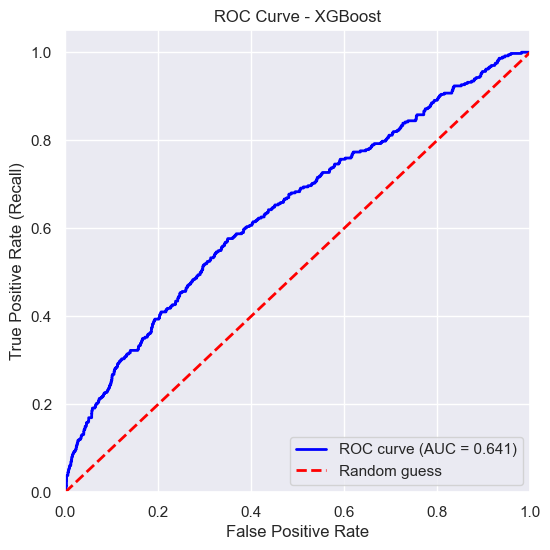

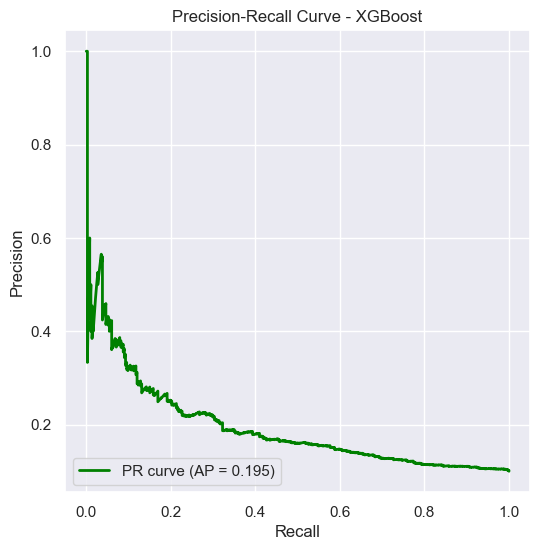

In [25]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %.3f)' % roc_auc)
plt.plot([0,1], [0,1], color='red', lw=2, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve - XGBoost')
plt.legend(loc="lower right")
plt.show()



from sklearn.metrics import precision_recall_curve, average_precision_score

precisions, recalls, _ = precision_recall_curve(y_test, y_prob)
avg_precision = average_precision_score(y_test, y_prob)

plt.figure(figsize=(6,6))
plt.plot(recalls, precisions, color='green', lw=2, label='PR curve (AP = %.3f)' % avg_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - XGBoost')
plt.legend(loc="lower left")
plt.show()

### 🔹 ROC Curve Interpretation
- X-axis = False Positive Rate, Y-axis = True Positive Rate (Recall).  
- The curve lies above the diagonal baseline → model performs better than random guessing.  
- AUC ≈ 0.64 → the model ranks churners higher than non-churners about 64% of the time.  
- However, the curve is close to the diagonal → weak separation ability.  

### 🔹 Precision-Recall Curve Interpretation
- X-axis = Recall, Y-axis = Precision.  
- Precision is high only when recall is very low (model is very selective).  
- As recall increases, precision drops quickly (<0.2).  
- Average Precision ≈ 0.20 → confirms trade-off seen in threshold tuning.  
- Business implication: catching more churners means sending more false alarms (offers to non-churners).  


# 📊 Comparison Across Attempts

To evaluate progress, the table below summarizes the performance of all three approaches on the **original test set**.

| Attempt | Model / Technique                  | Accuracy | Precision (Churn) | Recall (Churn) | F1 (Churn) | ROC-AUC |
|---------|------------------------------------|----------|-------------------|----------------|------------|---------|
| 1       | Random Forest (tuned)              | 0.90     | 0.76              | 0.07           | 0.13       | 0.659   |
| 2       | Random Forest + SMOTE (tuned)      | 0.90     | 0.51              | 0.10           | 0.17       | 0.657   |
| 3       | XGBoost + Recall Focus (0.5 thr)   | 0.70     | 0.16              | 0.48           | 0.24       | 0.641   |
| 3*      | XGBoost + Threshold=0.3 (tuned)    | ~0.60    | 0.10              | 0.97           | ~0.18      | ~0.64   |

---

### 🔹 Key Observations
- **Attempt 1 (RF tuned):**  
  - Excellent accuracy (90%), but recall for churners was only **7%** → most churners missed.  

- **Attempt 2 (RF + SMOTE):**  
  - Balanced training improved churn recall slightly (**7% → 10%**), but still very weak.  
  - Accuracy and AUC remained unchanged.  

- **Attempt 3 (XGBoost recall-focused):**  
  - Recall improved drastically (**48% at default threshold**).  
  - At lower threshold (0.3), recall reached **97%**, but precision dropped to ~10%.  
  - Accuracy also dropped (70% → 60%) because the model predicts many more churners.  

---

### 🔹 Business Interpretation
- For churn prediction, **recall is more important than accuracy**.  
- Missing churners (false negatives) means **lost revenue**, while false positives only mean offering incentives to loyal customers (lower cost).  
- Therefore, **XGBoost with threshold tuning** is the most practical solution:  
  - Even though accuracy is lower, it can **identify almost all churners**.  
  - This gives the business an opportunity to intervene with retention strategies.  

# ✅ Conclusion

### 🔹 Findings
1. **Random Forest (tuned)**  
   - Accuracy = 90%, but recall for churners = 7%.  
   - Looks good on paper, fails in practice (accuracy paradox).  

2. **Random Forest + SMOTE**  
   - Balanced training improved recall slightly (10%).  
   - Still missed 90% churners → not business-useful.  

3. **XGBoost + Recall Focus**  
   - Recall improved significantly: 48% at threshold=0.5, ~97% at threshold=0.3.  
   - Precision dropped (~10–16%), but acceptable in churn context.  
   - ROC-AUC (~0.64) shows weak but consistent separation.  

### 🔹 Business Perspective
- **Recall is more valuable than accuracy** in churn prediction.  
- False negatives (missed churners) = lost customers & revenue.  
- False positives (wrongly flagged loyal customers) = cost of offering incentives (much lower).  
- Therefore, **XGBoost with threshold tuning** is the best solution among tested models.  

### 🔹 Next Steps
- Perform **cost-benefit analysis** to pick the best threshold (e.g., 0.3 vs 0.4).  
- Explore **LightGBM or CatBoost** for potentially better performance.  
- Consider **feature engineering** (domain-specific churn indicators) which often improves recall more than model changes.  
